In [ ]:
!pip3 install influxdb-client
!pip3 install tensorflow
!pip3 install pandas
!pip3 install numpy
!pip3 install sklearn
!pip3 install matplotlib
!pip3 install scalecast
!pip3 install seaborn
!pip3 install keras
!pip3 install darts
# brew install libomp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 744.1/744.1 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.8/217.8 kB 26.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.9 MB/s et

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import keras
from influxdb_client import InfluxDBClient, Point, WriteOptions
from influxdb_client.client.warnings import MissingPivotFunction
from sklearn.model_selection import train_test_split
from scalecast.Forecaster import Forecaster
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.callbacks import EarlyStopping
from darts import TimeSeries
import seaborn as sns
import time
import warnings
sns.set(rc={'figure.figsize':(25,8)})

In [ ]:
# Reading data from DB

# InfluxDB credentials and details
url = "http://kammeyer.uk:8086"
token = "9V1NYZbTXZkbf9H0Szf8Gl-dOaqrl97TmdC9gwNhxkRCgAcHR7jGSxnPtwHq2vBL-UOd607yPlROxlJAhRAwqw=="
org = "messme"

# Initialize InfluxDB Client
client = InfluxDBClient(url=url, token=token, org=org)

# Define the query for the 'energy' bucket
query = """
from(bucket: "energy")
  |> range(start: -2y)
  |> filter(fn: (r) => r._measurement == "energy_production")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""


# Fetch data into a DataFrame
start = time.time()
df = client.query_api().query_data_frame(query=query)
end = time.time()
print("Time taken to read the data is : ", end-start)
df.head()

Time taken to read the data is :  43.44515323638916


,result,table,_start,_stop,_time,_measurement,region,Biomasse,Braunkohle,Erdgas,Kernenergie,Photovoltaik,Pumpspeicher,Sonstige Erneuerbare,Sonstige Konventionelle,Steinkohle,Wasserkraft,Wind Offshore,Wind Onshore
0,_result,0,2022-02-04 00:31:35.846028+00:00,2024-02-04 12:31:35.846028+00:00,2022-02-04 00:45:00+00:00,energy_production,DE,1122.75,3093.75,1198.25,1018.75,0.0,5.25,44.5,354.00,1658.25,251.00,1478.25,3777.75
1,_result,0,2022-02-04 00:31:35.846028+00:00,2024-02-04 12:31:35.846028+00:00,2022-02-04 01:00:00+00:00,energy_production,DE,1120.00,3149.50,1164.50,1019.25,0.0,6.00,44.5,354.25,1566.50,255.00,1424.50,3765.25
2,_result,0,2022-02-04 00:31:35.846028+00:00,2024-02-04 12:31:35.846028+00:00,2022-02-04 01:15:00+00:00,energy_production,DE,1120.75,3163.00,1155.75,1019.00,0.0,6.00,44.5,353.75,1522.75,254.50,1429.00,3774.50
3,_result,0,2022-02-04 00:31:35.846028+00:00,2024-02-04 12:31:35.846028+00:00,2022-02-04 01:30:00+00:00,energy_production,DE,1119.50,3169.75,1165.50,1019.25,0.0,16.00,44.5,354.50,1517.25,252.50,1428.25,3840.50
4,_result,0,2022-02-04 00:31:35.846028+00:00,2024-02-04 12:31:35.846028+00:00,2022-02-04 01:45:00+00:00,energy_production,DE,1121.00,3162.00,1167.00,1019.00,0.0,18.00,44.5,353.50,1527.75,251.75,1433.75,3862.75


In [ ]:
# drop extra columns
columns_to_drop = ['result', '_start', '_stop', '_measurement', 'region']
df = df.drop(columns=columns_to_drop, inplace=False)

# Set index
df['_time'] = pd.to_datetime(df['_time'])
df = df.set_index('_time')

# Sort the DataFrame by index
df = df.sort_index()

df_Wind_Onshore = df[["Wind Onshore"]]

print(df_Wind_Onshore)
nan_count = df_Wind_Onshore.isna().sum()
print("df_Wind_Onshore shape is : ", df_Wind_Onshore.shape)
print("Number of NaN values in 'Wind Onshore' column:", nan_count)
df_Wind_Onshore = df_Wind_Onshore.ffill() # forward filling missing values
print("df_Wind_Onshore_cleaned shape is : ", df_Wind_Onshore.shape)

                           Wind Onshore
_time                                  
2022-02-04 00:45:00+00:00       3777.75
2022-02-04 01:00:00+00:00       3765.25
2022-02-04 01:15:00+00:00       3774.50
2022-02-04 01:30:00+00:00       3840.50
2022-02-04 01:45:00+00:00       3862.75
...                                 ...
2024-02-04 07:45:00+00:00           NaN
2024-02-04 08:00:00+00:00           NaN
2024-02-04 08:15:00+00:00           NaN
2024-02-04 08:30:00+00:00           NaN
2024-02-04 08:45:00+00:00           NaN

[70081 rows x 1 columns]
df_Wind_Onshore shape is :  (70081, 1)
Number of NaN values in 'Wind Onshore' column: Wind Onshore    410
dtype: int64
df_Wind_Onshore_cleaned shape is :  (70081, 1)


In [ ]:
df_Wind_Onshore.head()

,Wind Onshore
_time,
2022-02-04 00:45:00+00:00,3777.75
2022-02-04 01:00:00+00:00,3765.25
2022-02-04 01:15:00+00:00,3774.50
2022-02-04 01:30:00+00:00,3840.50
2022-02-04 01:45:00+00:00,3862.75


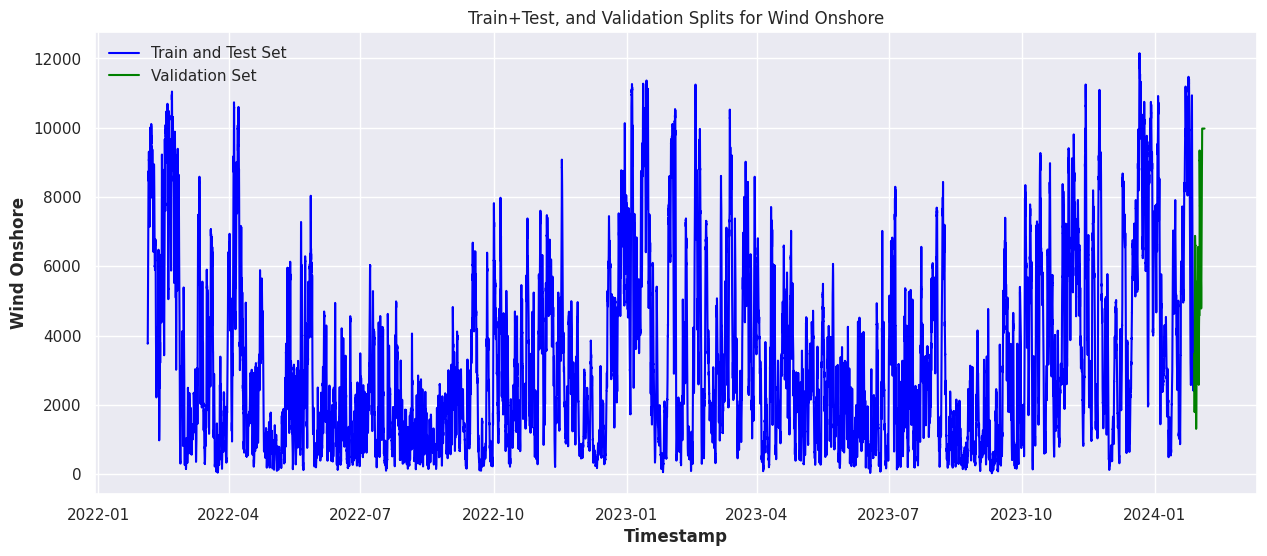

In [ ]:
# Train, Test and Validation Splits
train_test_data = df_Wind_Onshore[:-672].copy()

# Split data into train, test, and validation sets
validation_data = df_Wind_Onshore[-672:]

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(train_test_data.index, train_test_data['Wind Onshore'], label='Train and Test Set', color='blue')
plt.plot(validation_data.index, validation_data['Wind Onshore'], label='Validation Set', color='green')

plt.title('Train+Test, and Validation Splits for Wind Onshore')
plt.xlabel('Timestamp')
plt.ylabel('Wind Onshore')
plt.legend()
plt.show()

In [ ]:
f = Forecaster(y=train_test_data['Wind Onshore'], current_dates=train_test_data.index, freq='15T')

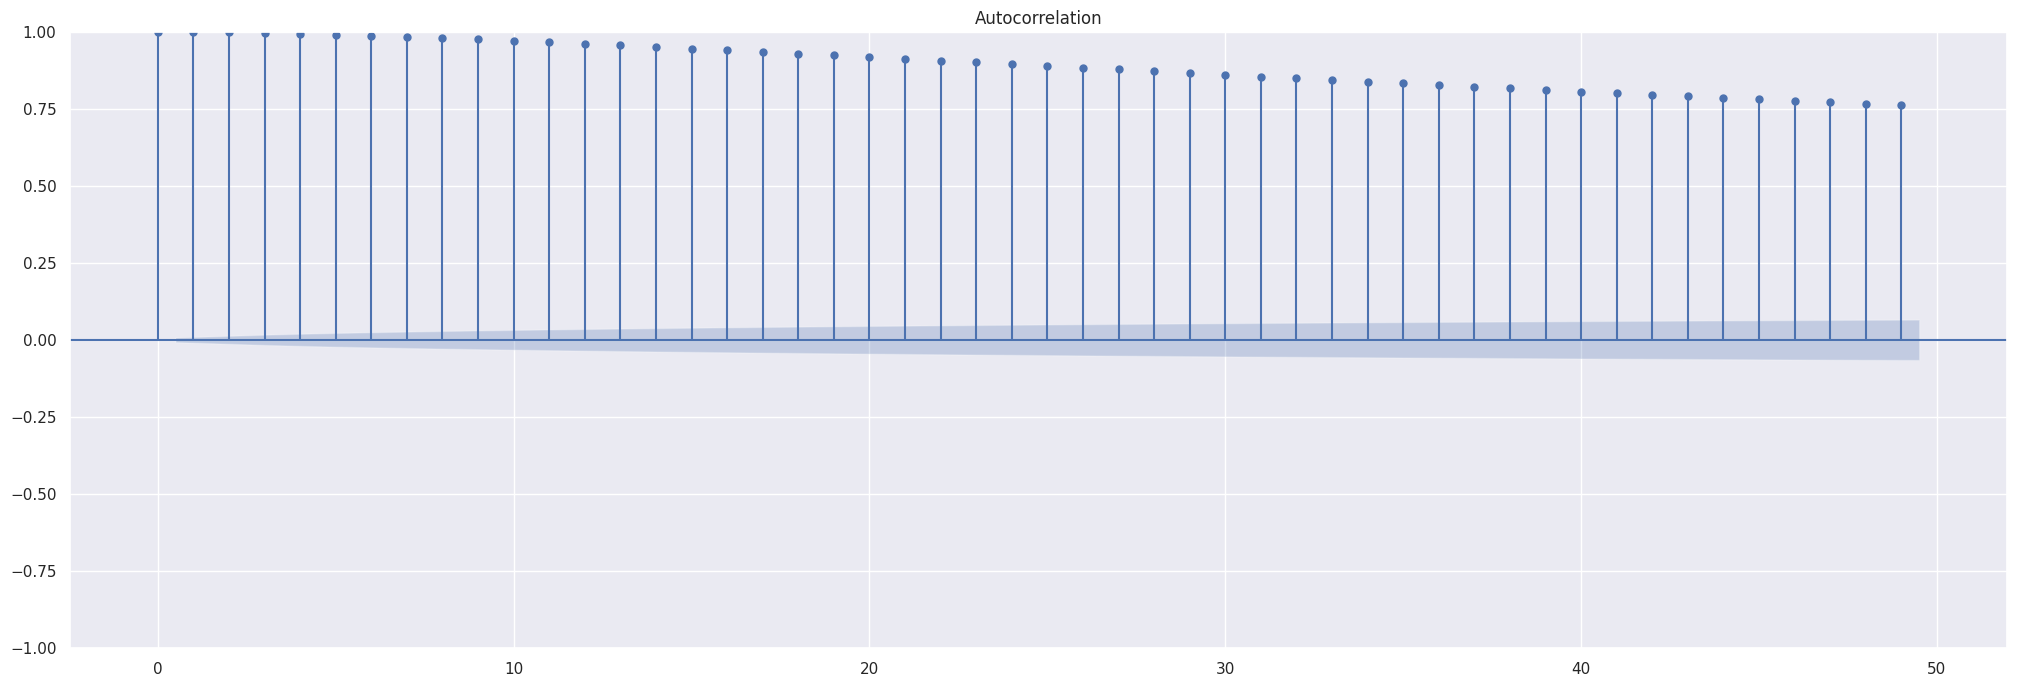

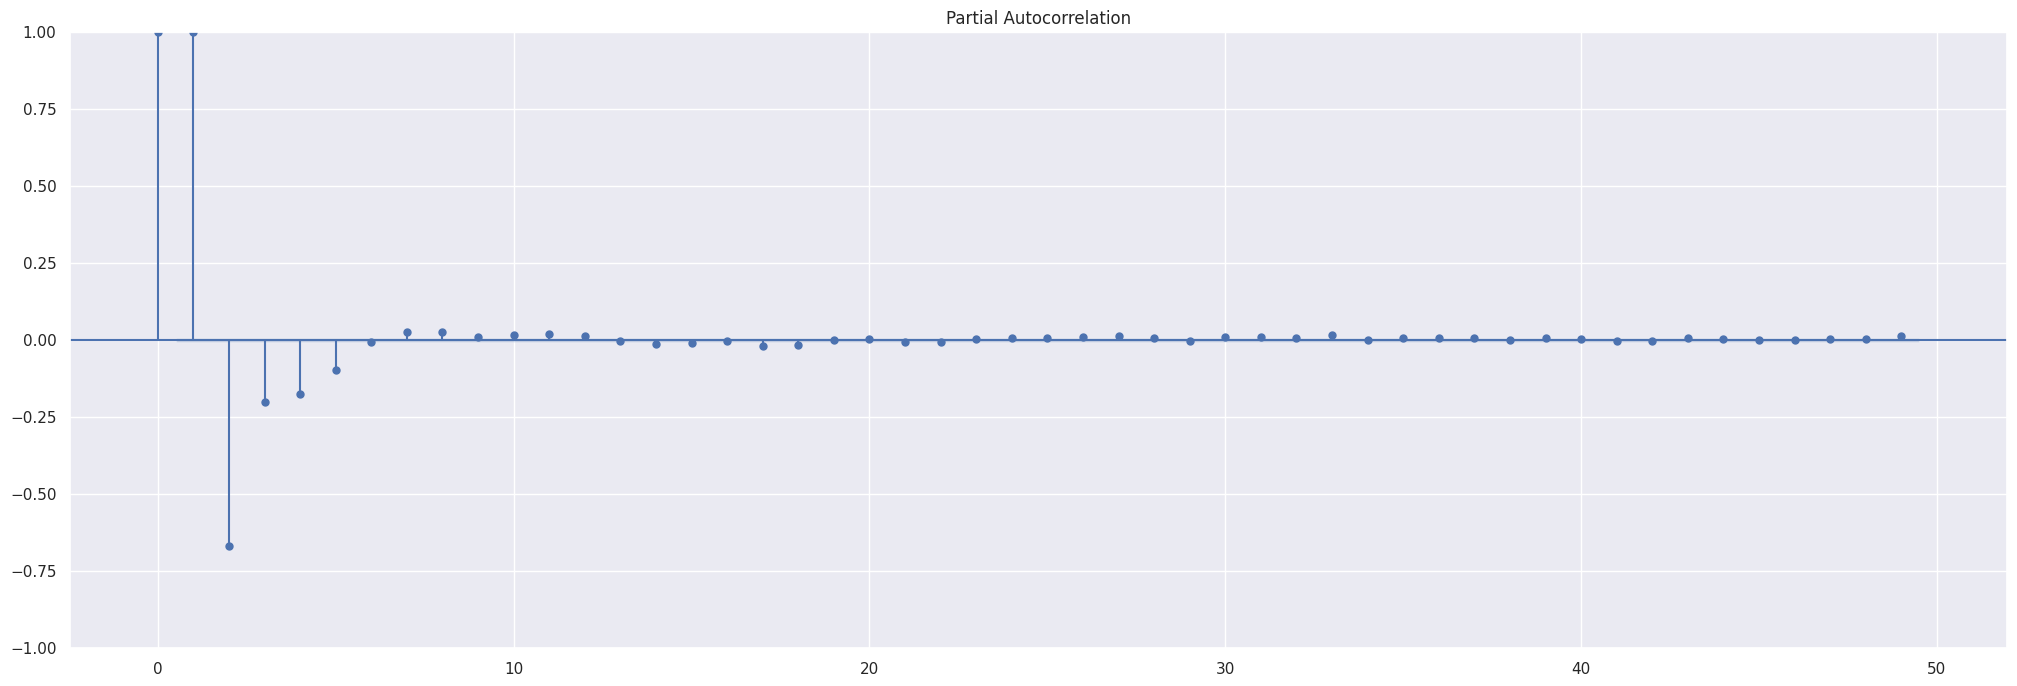

In [ ]:
f.plot_acf()
f.plot_pacf()
plt.show()

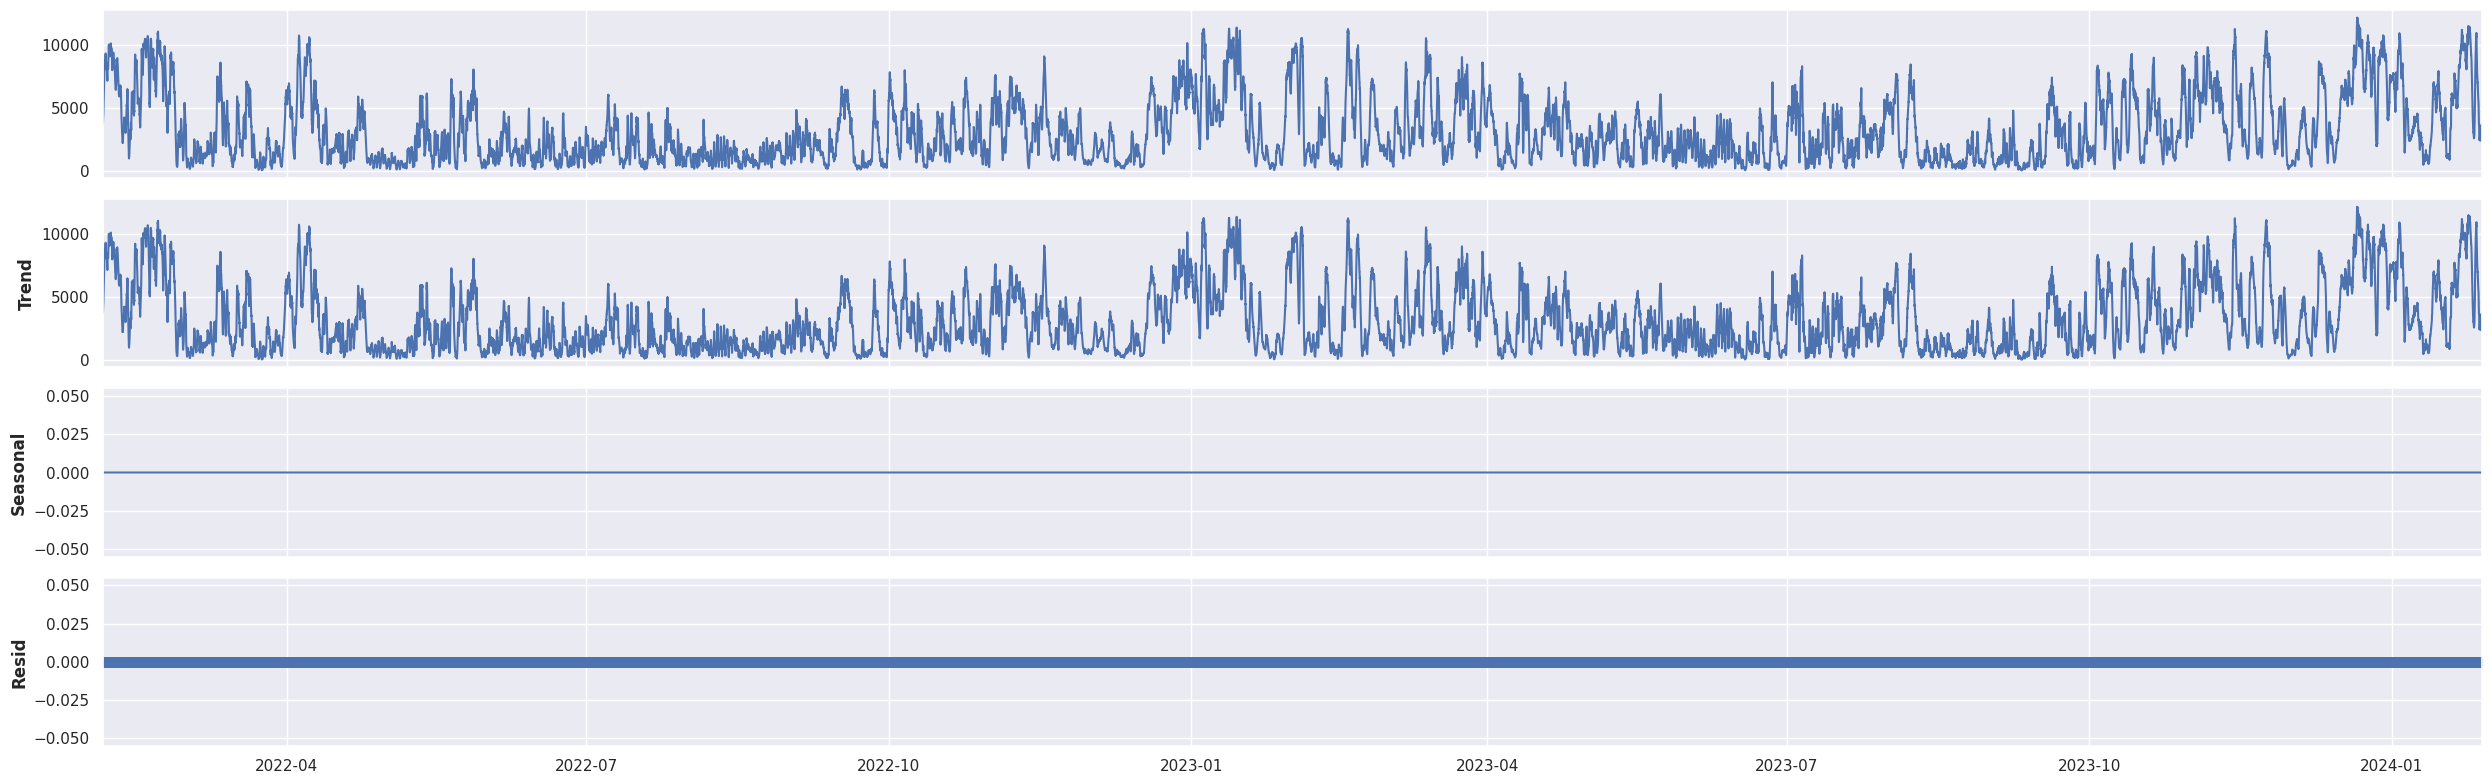

In [ ]:
# Perform seasonal decomposition
result = seasonal_decompose(train_test_data, model='additive', extrapolate_trend='freq', period=1)

# Plot the decomposed components
result.plot()
plt.show()

In [ ]:
is_stationary = f.adf_test(full_res=False)
print(is_stationary)

True


In [ ]:
f.set_test_length(0.10)

In [ ]:
f.eval_cis()

In [ ]:
f.add_time_trend()

In [ ]:
f.add_seasonal_regressors('month','quarter','week','dayofyear',raw=False,sincos=True)
f.add_seasonal_regressors('dayofweek','is_leap_year','week',raw=False,dummy=True,drop_first=True)
f.add_seasonal_regressors('year')

In [ ]:
f.generate_future_dates(1344)
f.set_estimator('lstm')

Epoch 1/25
1561/1561 [==============================] - 32s 15ms/step - loss: 0.1465 - val_loss: 0.1523
Epoch 2/25
1561/1561 [==============================] - 22s 14ms/step - loss: 0.1455 - val_loss: 0.1537
Epoch 3/25
1561/1561 [==============================] - 22s 14ms/step - loss: 0.1451 - val_loss: 0.1517
Epoch 4/25
1561/1561 [==============================] - 22s 14ms/step - loss: 0.1448 - val_loss: 0.1532
Epoch 5/25
1561/1561 [==============================] - 22s 14ms/step - loss: 0.1444 - val_loss: 0.1541
Epoch 6/25
1561/1561 [==============================] - 22s 14ms/step - loss: 0.1440 - val_loss: 0.1529
Epoch 7/25
1561/1561 [==============================] - 22s 14ms/step - loss: 0.1433 - val_loss: 0.1529
Epoch 8/25
1561/1561 [==============================] - 21s 14ms/step - loss: 0.1425 - val_loss: 0.1542
Epoch 9/25
1561/1561 [==============================] - 22s 14ms/step - loss: 0.1418 - val_loss: 0.1546
Epoch 10/25
1561/1561 [==============================] - 23s 15m

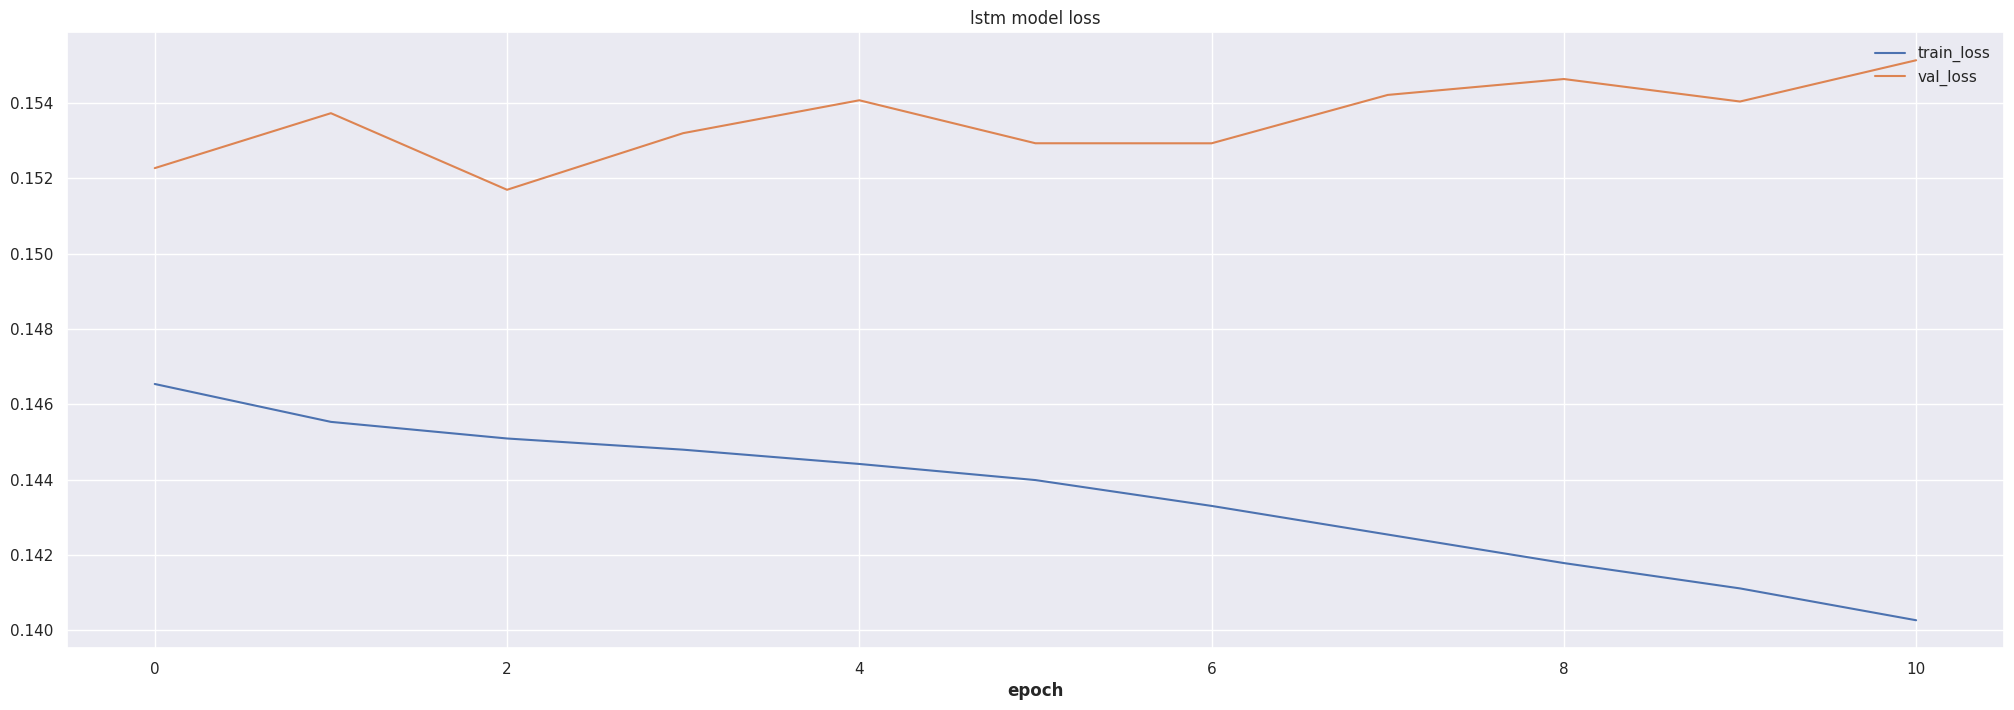

Epoch 1/25
1914/1914 [==============================] - 35s 15ms/step - loss: 0.1404 - val_loss: 0.2367
Epoch 2/25
1914/1914 [==============================] - 25s 13ms/step - loss: 0.1388 - val_loss: 0.2352
Epoch 3/25
1914/1914 [==============================] - 26s 13ms/step - loss: 0.1385 - val_loss: 0.2399
Epoch 4/25
1914/1914 [==============================] - 26s 14ms/step - loss: 0.1381 - val_loss: 0.2348
Epoch 5/25
1914/1914 [==============================] - 26s 14ms/step - loss: 0.1378 - val_loss: 0.2343
Epoch 6/25
1914/1914 [==============================] - 26s 14ms/step - loss: 0.1374 - val_loss: 0.2375
Epoch 7/25
1914/1914 [==============================] - 26s 14ms/step - loss: 0.1370 - val_loss: 0.2325
Epoch 8/25
1914/1914 [==============================] - 27s 14ms/step - loss: 0.1366 - val_loss: 0.2378
Epoch 9/25
1914/1914 [==============================] - 26s 14ms/step - loss: 0.1362 - val_loss: 0.2353
Epoch 10/25
1914/1914 [==============================] - 26s 14m

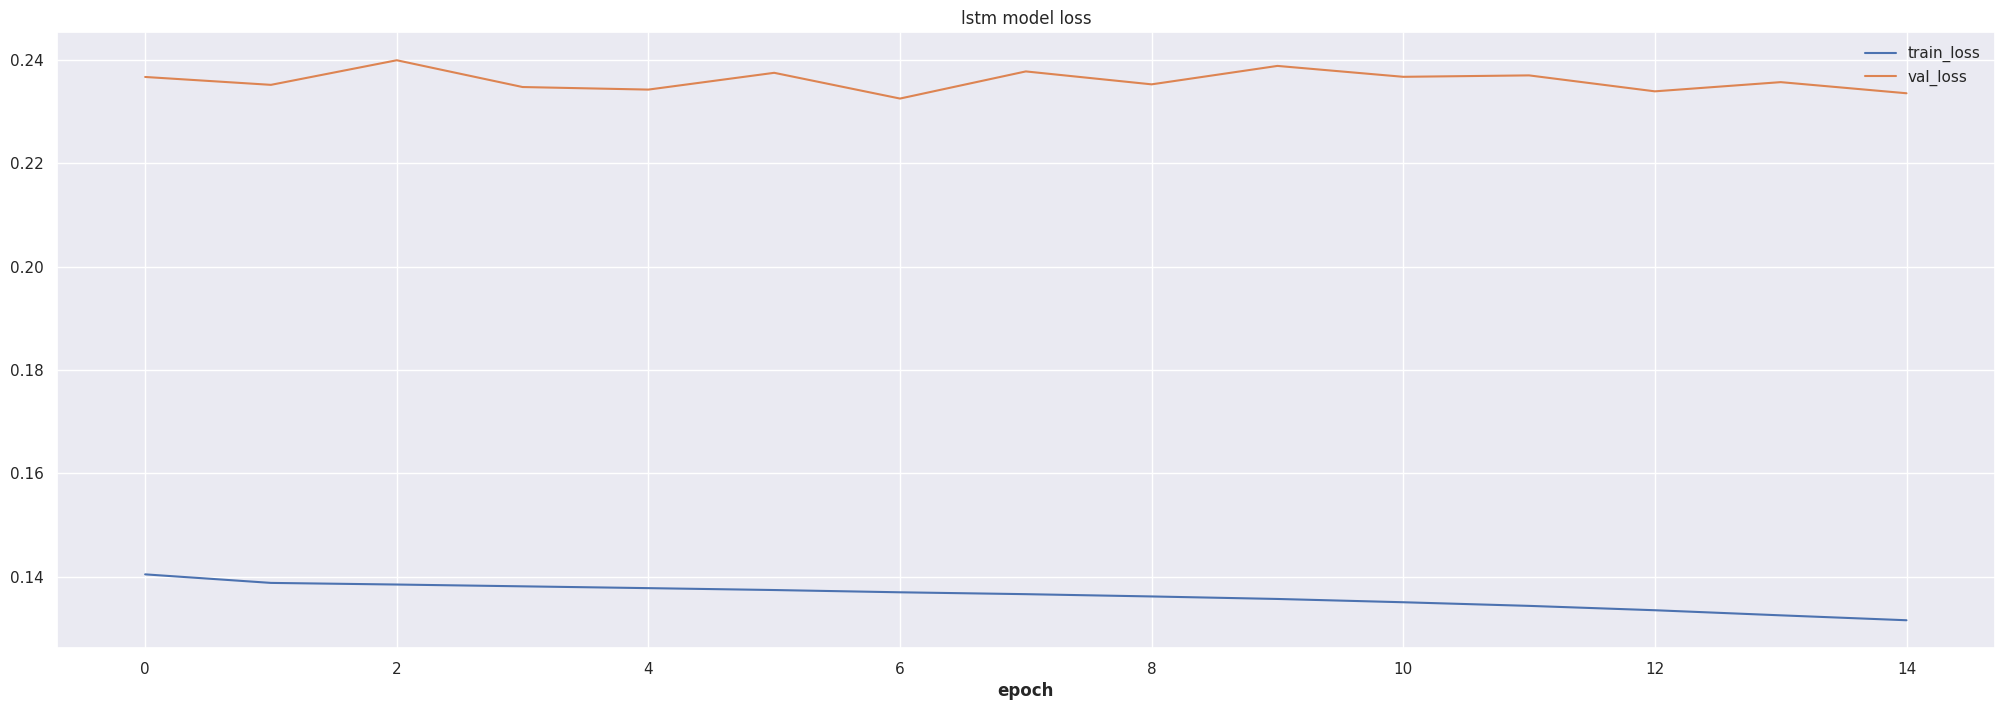

In [ ]:
f.manual_forecast(call_me='lstm_best',
                  lags=36,
                  batch_size=32,
                  epochs=25,
                  validation_split=0.1,
                  activation='tanh',
                  optimizer='Adam',
                  learning_rate=0.001,
                  callbacks=EarlyStopping(monitor='val_loss',
                                          patience=8),
                  lstm_layer_sizes=(72,)*4,
                  dropout=(0,)*4,
                  plot_loss=True)

Mean Absolute Error (MAE) prediction vs validation set : 3306.7814016320212


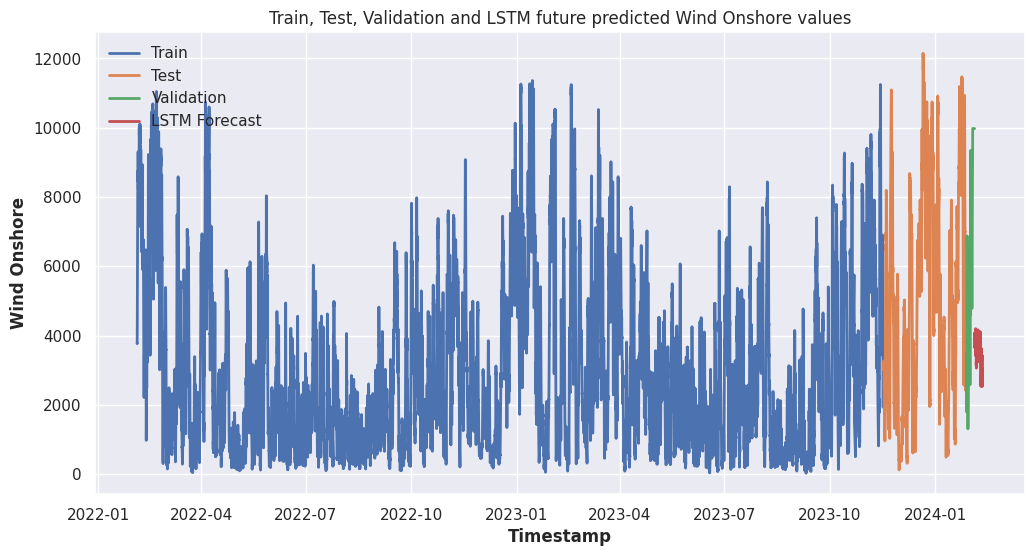

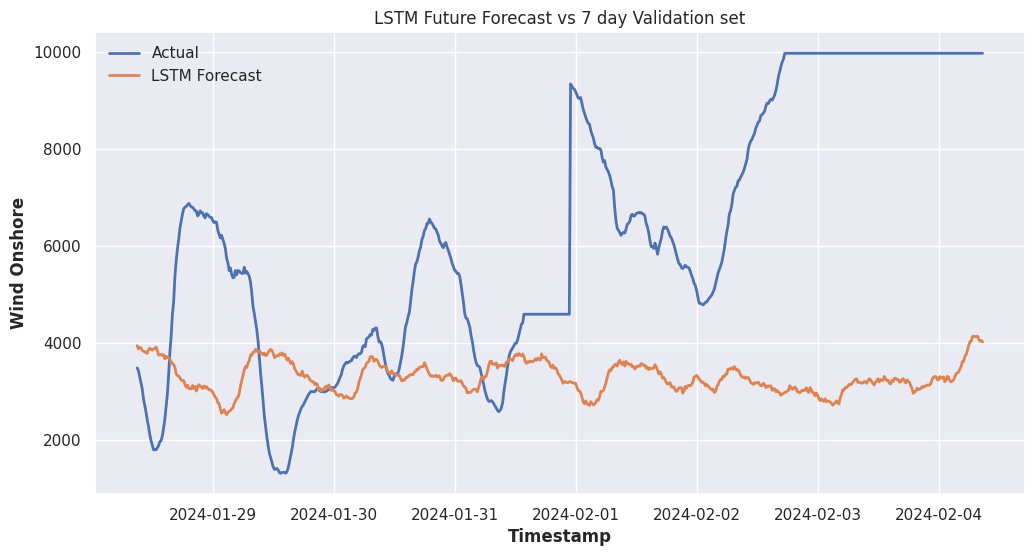

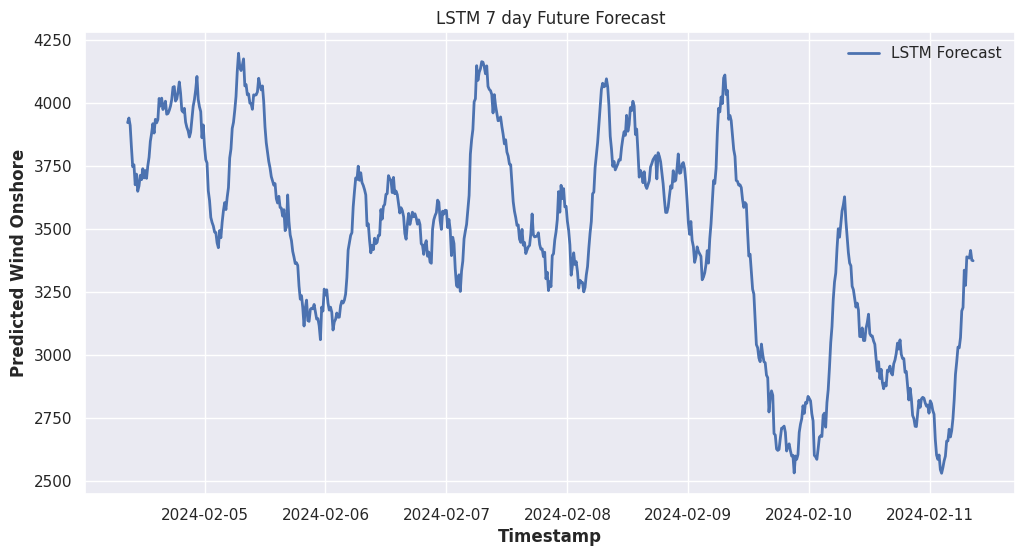

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error


# Get future forecast values and index
lstm_default_forecasted_df = f.export('lvl_fcsts')
last_timestamp = validation_data.index[-1]
new_index = pd.date_range(start=last_timestamp, periods=672, freq='15T')
existing_index_series = pd.Series(validation_data.index)
new_index_series = pd.Series(new_index)
concatenated_series = pd.concat([existing_index_series, new_index_series])
lstm_default_forecasted_df.index = concatenated_series

# Calculate MAE
mae = mean_absolute_error(validation_data["Wind Onshore"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
mape = mean_absolute_percentage_error(validation_data["Wind Onshore"].values, lstm_default_forecasted_df["lstm_best"].values[:672])
rmse = root_mean_squared_error(validation_data["Wind Onshore"].values, lstm_default_forecasted_df["lstm_best"].values[:672])


# Add more metrics here
print(f'Mean Absolute Error (MAE) prediction vs validation set : {mae}')
print(f'Mean Absolute Percentage Error (MAPE) prediction vs validation set : {mape*100:.2f}%')
print(f'Root Mean Squared Error (RMSE) prediction vs validation set : {rmse}')

# Split train_test_data into separate train and test sets and train_index and test_index
train_index, test_index = train_test_split(train_test_data.index, test_size=0.1, shuffle=False, random_state=42)
train,test = train_test_split(train_test_data["Wind Onshore"], test_size=0.1, shuffle=False, random_state=42)


# Plotting train+test, validation and future predictions together
plt.figure(figsize=(12, 6))
plt.plot(train_index, train, label='Train', linewidth=2)
plt.plot(test_index, test, label='Test', linewidth=2)
plt.plot(validation_data.index, validation_data["Wind Onshore"], label='Validation', linewidth=2)
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Wind Onshore')
plt.title('Train, Test, Validation and LSTM future predicted Wind Onshore values')
plt.legend()
plt.show()

# Plotting simulated future with validation
plt.figure(figsize=(12, 6))
plt.plot(validation_data.index, validation_data["Wind Onshore"], label='Actual', linewidth=2)
plt.plot(validation_data.index, lstm_default_forecasted_df["lstm_best"][:672], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Wind Onshore')
plt.title('LSTM Future Forecast vs 7 day Validation set')
plt.legend()
plt.show()

# Plotting real future
plt.figure(figsize=(12, 6))
plt.plot(lstm_default_forecasted_df.index[672:], lstm_default_forecasted_df["lstm_best"][672:], label='LSTM Forecast', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Predicted Wind Onshore')
plt.title('LSTM 7 day Future Forecast')
plt.legend()
plt.show()


In [ ]:
forecasted_values = lstm_default_forecasted_df["lstm_best"][672:]
forecasted_values
forecasted_values.to_csv('Wind_Onshore_Future_7_days.csv', index_label='Timestamp', encoding='utf-8')

In [ ]:
forecasted_values_corrected = lstm_default_forecasted_df["lstm_best"][:672].values

combined_df = pd.DataFrame({
    'Timestamp': validation_data.index,
    'Actual Wind Onshore': validation_data['Wind Onshore'].values,
    'Forecasted Wind Onshore': forecasted_values_corrected
})

# Export to CSV
combined_df.to_csv('Wind_Onshore_Actual_vs_Forecasted.csv', index=False, encoding='utf-8')

                  Timestamp  Actual Wind Onshore  Forecasted Wind Onshore
0 2024-01-28 09:00:00+00:00              3482.75              3940.608596
1 2024-01-28 09:15:00+00:00              3426.50              3875.470968
2 2024-01-28 09:30:00+00:00              3300.00              3905.036204
3 2024-01-28 09:45:00+00:00              3179.25              3895.031988
4 2024-01-28 10:00:00+00:00              3055.25              3846.367598
